# Code stuff - not slides!

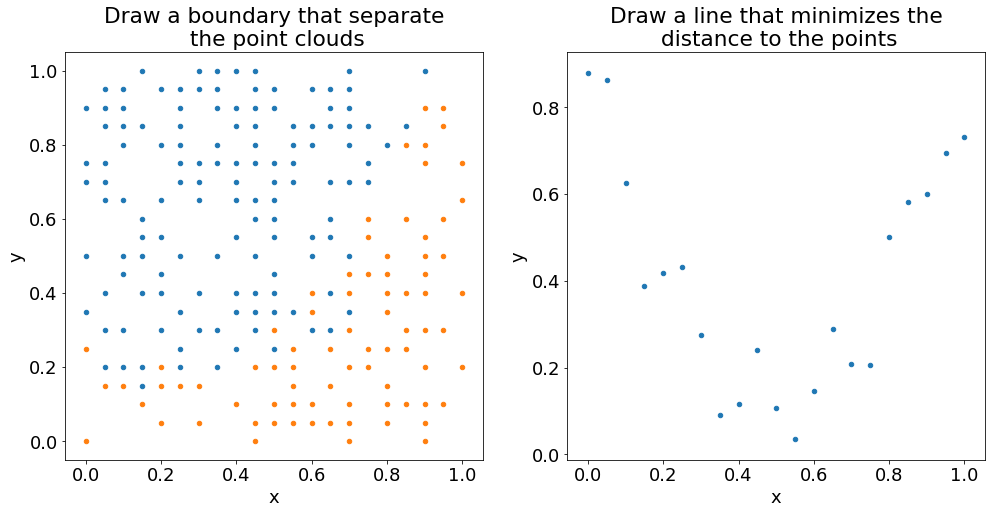

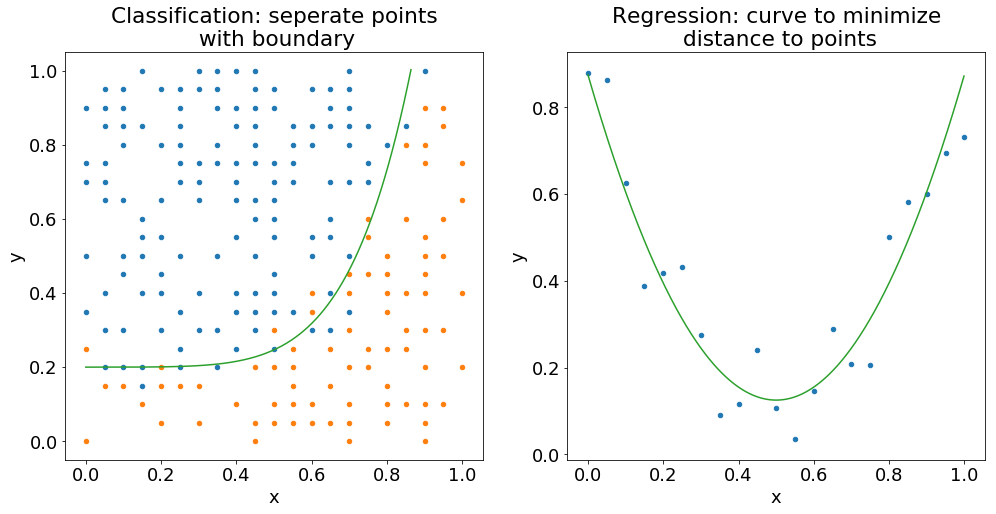

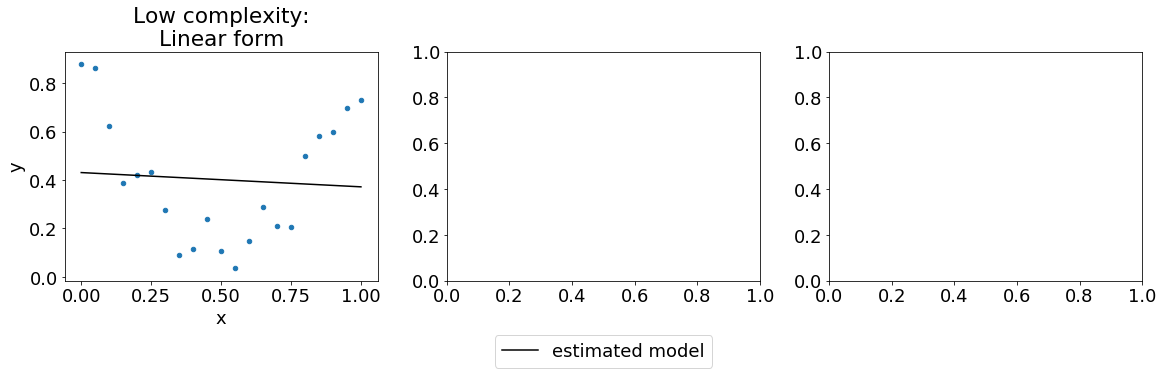

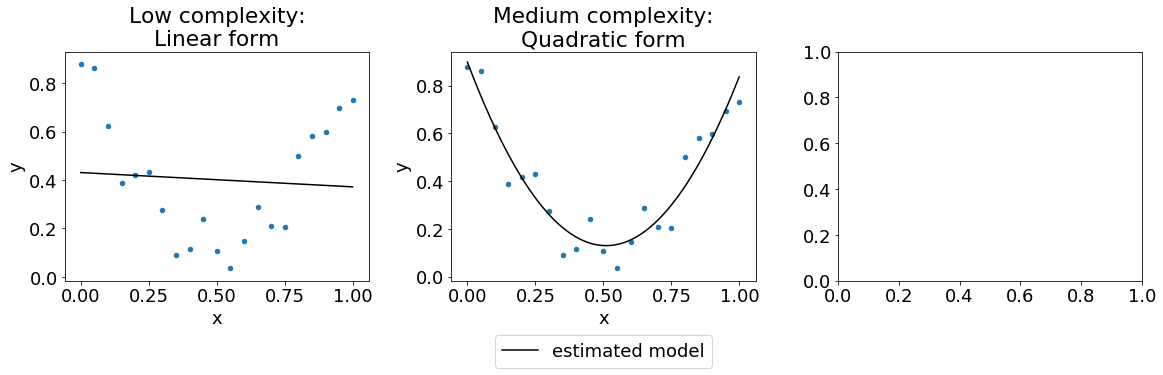

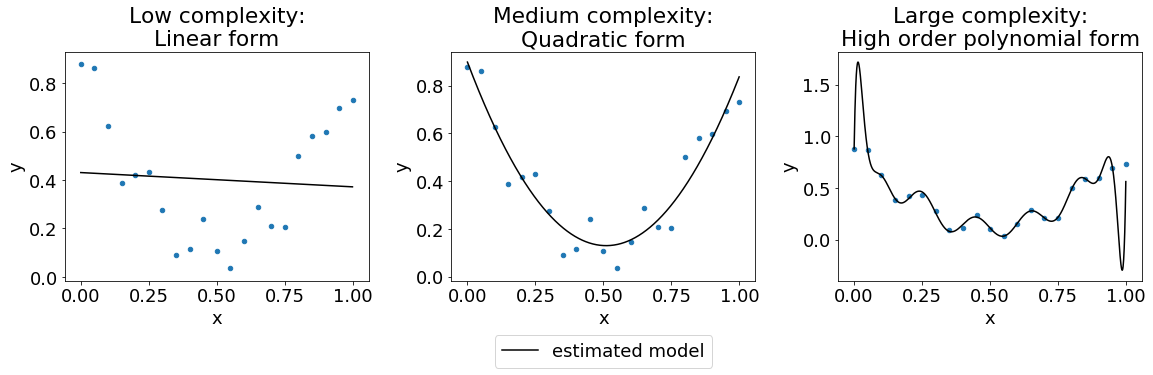

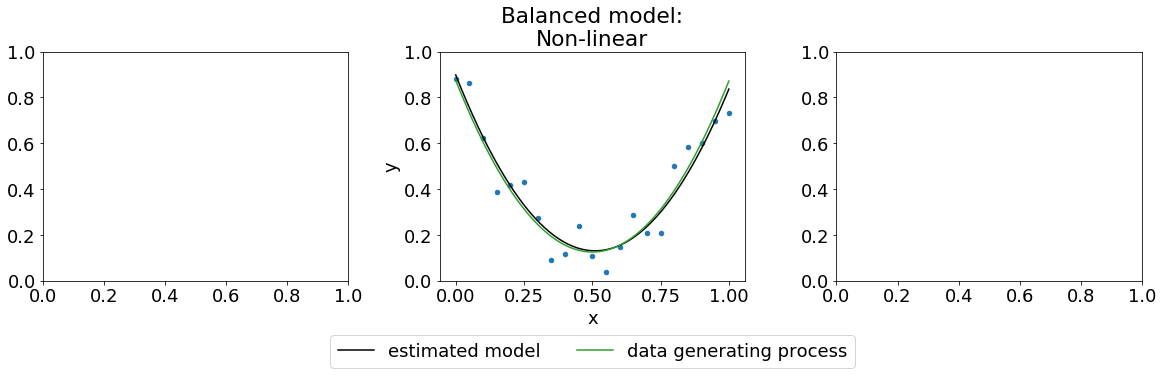

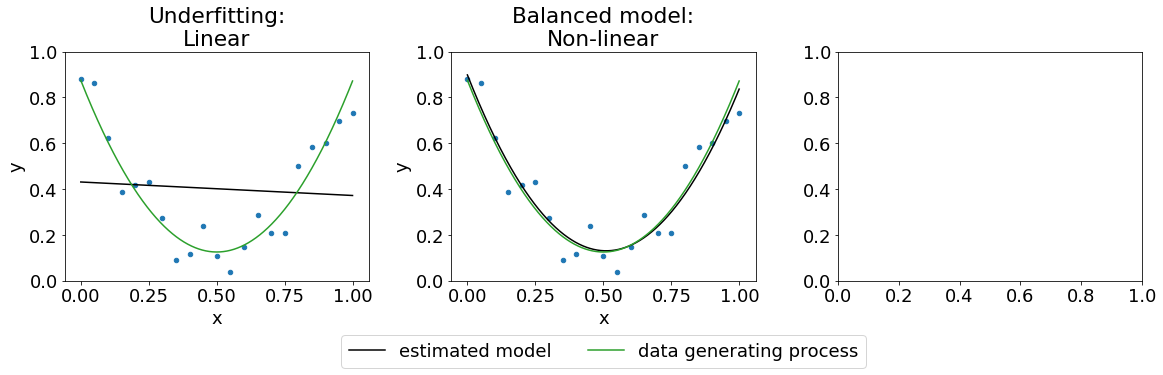

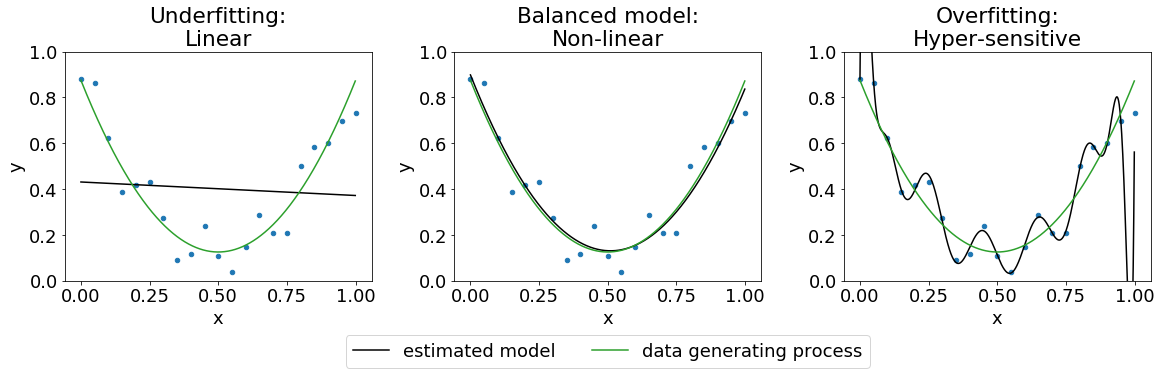

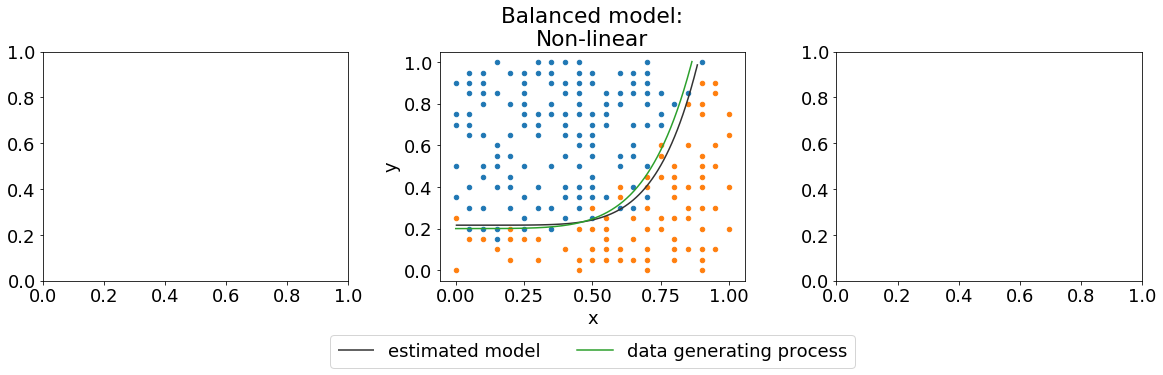

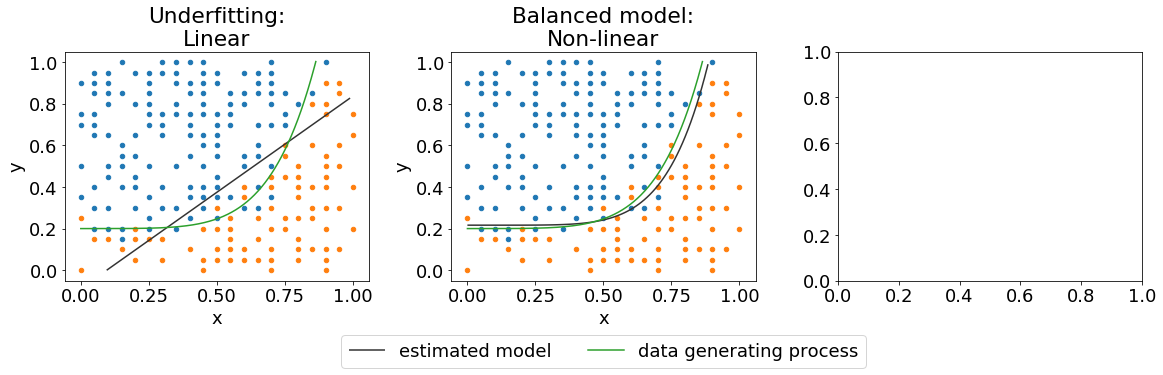

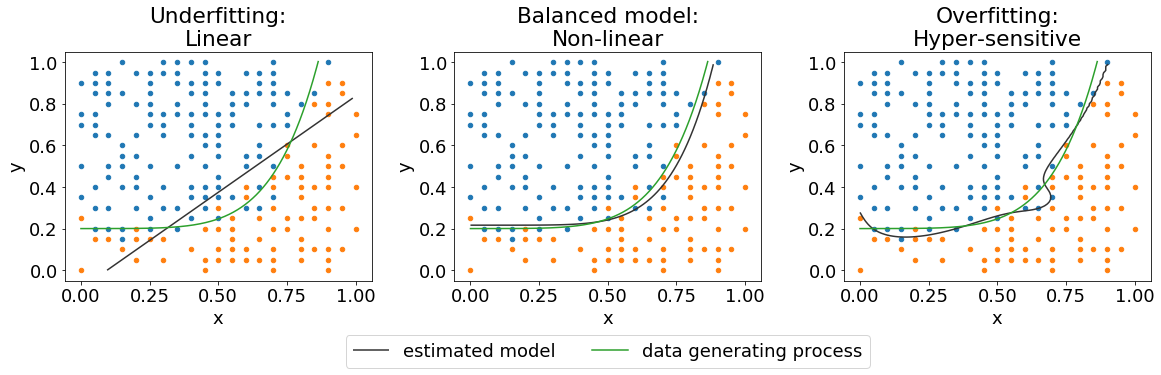

In [1]:
%run ../ML_plots.ipynb

# Session 13:
## Supervised learning, part 2

*Andreas Bjerre-Nielsen*

## Agenda
1. [model building](#Model-building) 
1. [model selection](#Model-selection) 
  - [cross validation](#Cross-validation)
  - [tools for selection](#Tools-for-model-selection)
1. [dimensionality reduction](#Dimensionality-reduction)  
1. [measures for classification](#Measures-for-classification)  


## Vaaaamos

In [51]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns

plt.style.use('default') # set style (colors, background, size, gridlines etc.)
plt.rcParams['figure.figsize'] = 10, 4 # set default size of plots
plt.rcParams.update({'font.size': 18})

## Supervised problems (1)
*What is the tradeoff for making supervised regression models?*

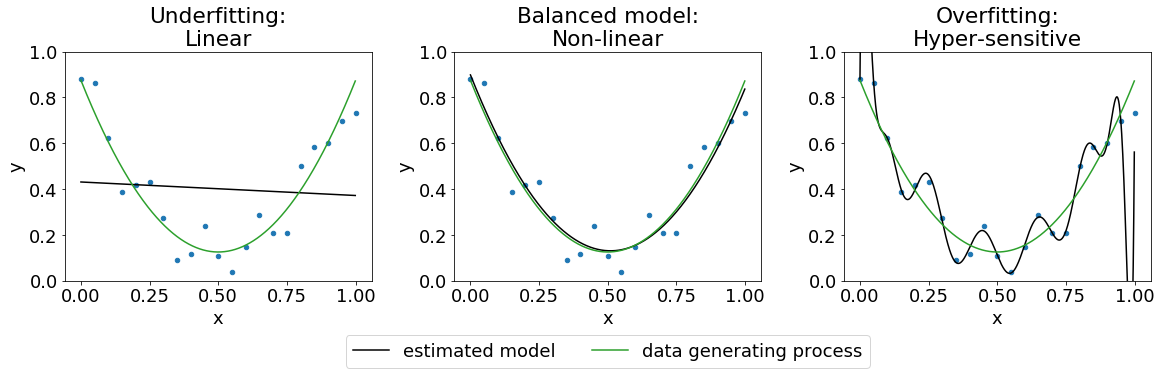

In [3]:
# f_bias_var['regression'][2]

## Supervised problems (2)
*What was a remedy to overfitting in linear models? How do we measure overfitting?*

Regularization
- Too many irrelevant features - solved by L1 regularization ~ lasso
- Exploding coefficients - solved by L2 regularization ~ ridge

# Model building 

## Model pipelines (1)
*Is there a smart way to build ML models?*

Yes, we build a pipeline:

- Preprocessing data
    - Standard: adding polynomials, imputation, rescaling
    - Unsupervised learning (more info..)
- Supervised learning

## Model pipelines (2)


<center><img src='https://github.com/rasbt/python-machine-learning-book-2nd-edition/raw/master/code/ch06/images/06_01.png' alt="Drawing" style="width: 900px;"/></center>


## Model pipelines (3)
*What are the advantages of using a pipeline?*

- Ensures good practice - we only fit on training data. 
- Much less code!

## Applying a model pipeline (1)
*What would this look like in Python?*

In [55]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

pipe_preproc = make_pipeline(PolynomialFeatures(), 
                             StandardScaler())

print(pipe_preproc.steps[0])
print(pipe_preproc.steps[1])

('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False))
('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True))


## Applying a model pipeline (2)
*Let's some load Boston house price data*

In [49]:
print('\n'.join(load_boston()['DESCR'].split('\n')[13:28]))

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        - MEDV     Median value of owner-occupied homes in $1000's


## Applying a model pipeline (3)
*And how do I apply the pipe on the data?*

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
X = load_boston().data
y = load_boston().target

print(load_boston().feature_names)

# splitting into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y)

# apply preproc - fit on train
pipe_preproc.fit(X_train) # fit to training
X_train_prep = pipe_preproc.transform(X_train) # transform training data
X_test_prep = pipe_preproc.transform(X_test) # transform test data

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


## Applying a model pipeline (4)
*And how do I apply the pipe on the data?*

In [56]:
# THE PIPE APPLIED

# apply preproc - fit on train
pipe_preproc = make_pipeline(PolynomialFeatures(), 
                             StandardScaler())

pipe_preproc.fit(X_train) # fit to training
X_train_prep = pipe_preproc.transform(X_train) # transform training data
X_test_prep = pipe_preproc.transform(X_test) # transform test data

# WITHOUT PIPE 
poly_trans = PolynomialFeatures()
scaler = StandardScaler()

X_train_poly = poly_trans.fit_transform(X_train) 
X_test_poly = poly_trans.fit_transform(X_test)

scaler.fit(X_train_poly)
X_train_prep_alt = scaler.transform(X_train_poly)
X_test_prep_alt = scaler.transform(X_test_poly)




# Model selection 


## Measuring the problem
*Does machine learning work out of the box?*

- In some cases ML works quite well out of the box.
- Often ML requires making careful choices.
    - Note that automated machine learning packages and services exist.

*Which choices are to be made?*

- We need to pick model building **hyperparameters**.
- E.g. $\lambda$ for Lasso, Ridge.

## Model validation (1)
*How do we measure our model's performance for different hyperparameters?*

- Remember we cannot use the test set.

*Could we somehow mimick what we do with test data?*

- Yes, we can split the remaining non-test data into training and validation data:
    - we train model for various hyperparameters on training data;
    - pick the hyperparameters which performs best on validation data.

## Model validation (2)
*The non-test data is split into training and validation*


<center><img src='https://github.com/rasbt/python-machine-learning-book-2nd-edition/raw/master/code/ch06/images/06_02.png' alt="Drawing" style="width: 950px;"/></center>


## Model validation (3)
*What would this look like in Python?*

In [57]:
# splitting into development (2/3) and test data (1/3)
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=1)

# splitting development into train (1/3) and validation (1/3)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=1/2, random_state=1)

## Model validation (4)
Let's train a linear regression model

In [7]:
from sklearn.linear_model import Lasso, LinearRegression
pipe_lr = make_pipeline(PolynomialFeatures(include_bias=False), 
                        StandardScaler(),
                        LinearRegression())

pipe_lr.fit(X_dev, y_dev)

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

## Model validation (5)
Let's find the  Lasso model which performs best in the validation set

In [59]:
from sklearn.metrics import mean_squared_error as mse

perform = []
lambdas = np.logspace(-4, 4, 33)
for lambda_ in lambdas:
    pipe_lasso = make_pipeline(PolynomialFeatures(include_bias=False), 
                               StandardScaler(),
                               Lasso(alpha=lambda_, random_state=1))
    pipe_lasso.fit(X_train, y_train)
    y_pred = pipe_lasso.predict(X_val)
    perform.append(mse(y_pred, y_val))
    
hyperparam_perform = pd.Series(perform,index=lambdas)

optimal = hyperparam_perform.nsmallest(1)    
print(optimal)

0.01    17.318434
dtype: float64


## Model validation (6)
Let's compare the performance of the Lasso vs. Linear Regression

In [60]:
pipe_lasso = make_pipeline(PolynomialFeatures(include_bias=False), 
                           StandardScaler(),
                           Lasso(alpha=optimal.index[0]))

pipe_lasso.fit(X_dev,y_dev)
print('Lasso', round(mse(pipe_lasso.predict(X_test),y_test), 3))
print('LinReg', round(mse(pipe_lr.predict(X_test),y_test), 3))

Lasso 12.382
LinReg 17.895


## Bias and variance (1)
*How do we describe the modelling error?*

From [Wikipedia Sunday, August 19, 2018](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff):

- model **bias**: _an error from erroneous assumptions in the learning algorithm_
  - oversimplification of models, cannot approximate all patterns found
  

- model **variance**: _an error from sensitivity to small fluctuations in the training set_
  - reacts too much to sample errors and thus finds too many spurious relations 

## Bias and variance (2)

- **over fitting**: low bias / high variance
    - traning our model captures all patterns but we also find some irrelevant
    - examples: Decision Trees, Support Vector Machines or Neural Networks
- **under fitting**: high bias / low variance
    - traning our model captures all patterns but we also find some irrelevant
    - examples: linear and logistic regression (without polynomial expansion)

## Bias and variance (3)
*Not so fast.. OLS is unbiased, right?*

 Yes, OLS is unbiased. But .. 
- Requires we know the true form of the model. 

*What happens if we introduce regularization?*
- Then model is no longer unbiased.

## Smarter validation
*Is this approach the smartest way for deciding on choice of hyperparameters?*

# NO


Our model choice depends a lot on which sample we pick. Could we use more of the data?

# Cross validation


## The holdout method
*How do we got the more out of the data?*

We reuse the data in the development set repeatedly
- We test on all the data
- Rotate which parts of data is used for test and train.

## Leave-one-out CV
*How do we got the most of the data?*

The most robust approach
- Each single observation in the training data we use the remaining data to train.
- Makes number of models equal to the number of observations
- Very computing intensive - does not scale!
LOOCV

## K fold method (1)
*How do balance computing time vs. overfitting?*

We split the sample into $K$ even sized test bins.
- For each test bin $k$ we use the remaining data for training.

Advantages:
- We use all our data for testing.
- Training is done with 100-(100/K) pct. of the data, i.e. 90 pct. for K=10.

## K fold method (2)
In K-fold cross validation we average the errors.

<center><img src='https://github.com/rasbt/python-machine-learning-book-2nd-edition/raw/master/code/ch06/images/06_03.png' alt="Drawing" style="width: 1100px;"/></center>

## K fold method (3)
*How would we use K-fold cross validation to select our model?*

In [61]:
from sklearn.model_selection import KFold
kfolds = KFold(n_splits=10)
mseCV = []

for lambda_ in lambdas:
    
    pipe_lassoCV = make_pipeline(PolynomialFeatures(degree=3, include_bias=False),
                                 StandardScaler(),
                                 Lasso(alpha=lambda_, random_state=1))    
    mseCV_ = []
    
    for train_idx, val_idx in kfolds.split(X_dev, y_dev):
        
        X_train, y_train, = X_dev[train_idx], y_dev[train_idx]
        X_val, y_val = X_dev[val_idx], y_dev[val_idx] 

        pipe_lassoCV.fit(X_train, y_train)
        
        mseCV_.append(mse(pipe_lassoCV.predict(X_val), y_val))    
    mseCV.append(mseCV_)

## K fold method (4)

In [70]:


optimalCV = pd.DataFrame(mseCV, index=lambdas).mean(axis=1).nsmallest(1)

pipe_lassoCV = make_pipeline(PolynomialFeatures(include_bias=False), 
                                StandardScaler(),
                                Lasso(alpha=optimalCV.index[0], random_state=1))

pipe_lassoCV.fit(X_dev,y_dev)

model_pipes = ('Lasso', pipe_lasso), ('Lasso CV', pipe_lassoCV),('LinReg', pipe_lr)

for model_name, model_pipe in model_pipes:
    score = mse(model_pipe.predict(X_test),y_test)
    print(model_name, round(score, 1))

Lasso 12.4
Lasso CV 12.4
LinReg 17.9


## Learning curves (1)
*What does a balanced model look like?*

<center><img src='https://github.com/rasbt/python-machine-learning-book-2nd-edition/raw/master/code/ch06/images/06_04.png' alt="Drawing" style="width: 600px;"/></center>

## Learning curves (2)

In [74]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = \
    learning_curve(estimator=pipe_lasso,
                   X=X_train,
                   y=y_train,
                   train_sizes=np.linspace(0.1, 1.0, 10),
                   scoring='neg_mean_squared_error',                 
                   cv=3)
    
mse_ = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                     'Test':-test_scores.mean(axis=1)})\
        .set_index(pd.Index(train_sizes,name='sample size'))    
print(mse_.head())

                   Test     Train
sample size                      
20           327.856169  0.040538
40            67.607438  0.836417
60            52.208482  1.592246
80            50.194690  1.911472
101           36.249970  3.419180


## Learning curves (3)

Text(0,0.5,'Mean squared error')

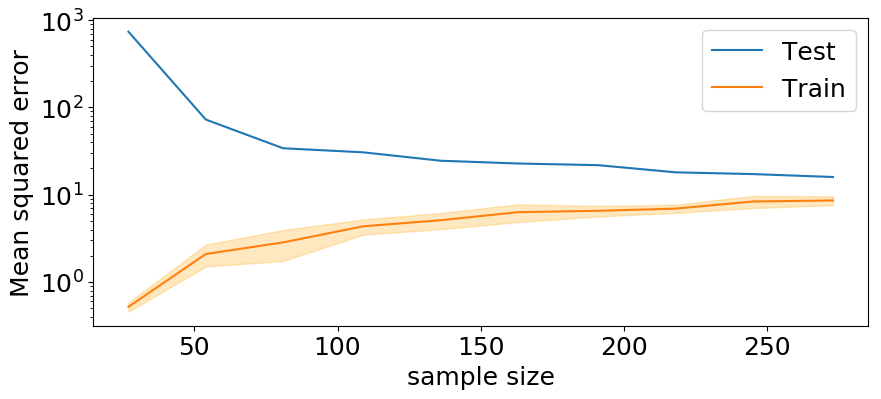

In [38]:
f_learn, ax = plt.subplots(figsize=(10,4))
mse_.plot(ax=ax, logy=True)
ax.fill_between(train_sizes,
                -train_scores.mean(1) + train_scores.std(1)*1.96,
                -train_scores.mean(1) - train_scores.std(1)*1.96, 
                alpha=0.25, 
                color='orange')
ax.set_ylabel('Mean squared error')

# Tools for model selection

## Validation curves (1)

In [78]:
from sklearn.model_selection import validation_curve

train_scores, test_scores = \
    validation_curve(estimator=pipe_lasso,
                     X=X_train,
                     y=y_train,
                     param_name='lasso__alpha',
                     param_range=lambdas,
                     scoring='neg_mean_squared_error',                 
                     cv=3)

mse_score = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                          'Validation':-test_scores.mean(axis=1),
                          'lambda':lambdas})\
              .set_index('lambda')   
print(mse_score.Test.nsmallest(1))

AttributeError: 'DataFrame' object has no attribute 'Test'

## Validation curves (2)

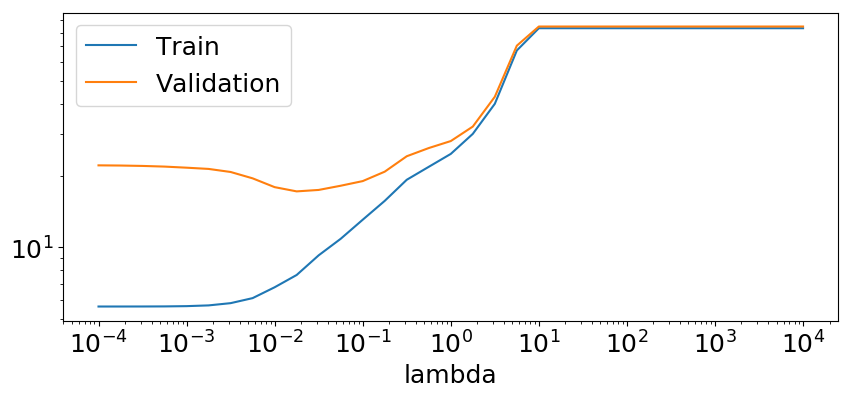

In [79]:
mse_score.plot(logx=True, logy=True)

## Grid search (1)
*How do we search for two or more optimal parameters?*

- Goal: find the optimal parameter combination: $$\lambda_1^*,\lambda_2^*=\arg\min_{\lambda_1,\lambda_2}MSE^{CV}(X_{train},y_{train})$$

- Option 1: We can loop over the joint grid of parameters.
  - One level for each parameter.
  - Caveats:

- Option 2: sklearn has `GridSearchCV` has a tool which tests all parameter combinations.

## Grid search (2)
*How does this look in Python?*

In [77]:
from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(estimator=pipe_lasso, 
                  param_grid={'lasso__alpha':lambdas}, 
                  scoring='neg_mean_squared_error', 
                  cv=10)

gs = gs.fit(X_train, y_train)
gs.best_params_

{'lasso__alpha': 0.01}

- Notation: double underscore between estimator and hyperparameter, e.g. 'est__hyperparam' 
- Scoring: negative MSE as we're maximizing the score ~ minimize MSE.

## Grid search (3)
*What if we have 10,000 parameter combinations?*

- Option 1: you buy a cluster on Amazon, learn how to parallelize across computers. Intro in last lecture.

- Option 2: you drop some of the parameter values

- Option 3: `RandomizedSearchCV` searches a subset of the combinations.

## Enhancing cross validation (1)

- Model validation does not consider that we are also tuning hyperparameters:
  - Leads too overfitting (Varma & Simon 2006; Cawley, Talbot 2010).
- Solution is **nested cross validation**.
  - Validation step should not be modelled as 1) train; 2) test.
  - Better way is 1) model selection: train, validate; 2) test.
  - Implement as pp 204-205 in Python for Machine Learning:
      - first inner loop: `GridSearchCV` 
      - second outer loop: `cross_val_score`

## Enhancing cross validation (1)
*Cross-val. suffers from the fact that it models test-train*

<center><img src='https://github.com/rasbt/python-machine-learning-book-2nd-edition/raw/master/code/ch06/images/06_07.png' alt="Drawing" style="width: 700px;"/></center>

# Dimensionality reduction

## Principal components analysis (1)
*How can we reducing the number of features?* 

One solution is finding the **principal components**. 
- essence: we get **fewer features** of **greater importance**.
- the new features are:
    - *uncorrelated* (i.e. linearly independent, orthogonal)
    - ordered so decreasing in how much variation of the feature data they explain

The method is called **principal components analysis**
  - corresponds to eigen decomposition of matrix into
      - principal eigenvectors (factors)
      - principal eigenvalues (factor importance)

## Principal components analysis (2)

Finding principal components for two features. Notice:
- The factors are orthogonal
- The first factor explains more variation, |PC1| > |PC2|

<center><img src='https://github.com/rasbt/python-machine-learning-book-2nd-edition/raw/master/code/ch05/images/05_01.png' alt="Drawing" style="width: 600px;"/></center>

## Principal components analysis (3)

We can plot the explained variation against the component indices, often called scree plot.

<center><img src='https://github.com/rasbt/python-machine-learning-book-2nd-edition/raw/master/code/ch05/images/05_02.png' alt="Drawing" style="width: 700px;"/></center>

## Principal components analysis (4)
*How do we choose the number of components?*


- Standard is to look for an *elbow* in the previous scree plot.

*What might go wrong about this approach??*

- The number of feautures should be a hyperparameter in the model building!!!

## Principal components analysis  (5)
*How does this look in Python?*

In [22]:
from sklearn.decomposition import PCA

pipe_pca_lasso = make_pipeline(PolynomialFeatures(include_bias=False), 
                               StandardScaler(),
                               PCA(),
                               Lasso())


gs = GridSearchCV(estimator=pipe_pca_lasso, 
                  param_grid={'lasso__alpha':lambdas, 
                              'pca__n_components':range(1, X_train.shape[1]+1)},
                  scoring='neg_mean_squared_error', 
                  cv=10)

gs = gs.fit(X_train, y_train)
gs.best_params_

{'lasso__alpha': 0.1778279410038923, 'pca__n_components': 13}

# Measures for classification

## Breakdown by error type (1)

We measure the accaracy as the rate of true predictions, i.e. $$ACC=\frac{TP+TN}{TP+TN+FP+FN}=\frac{True}{True+False}$$

where our measures are

<center><img src='https://github.com/rasbt/python-machine-learning-book-2nd-edition/raw/master/code/ch06/images/06_08.png' alt="Drawing" style="width: 400px;"/></center>

## Breakdown by error type (2)

Some powerful measures:

- Precision: share of predicted positive that are true
    - PRE = $\frac{TP}{TP+FP}$    
- Recall: share of actual positive that are true    
   - REC = $\frac{TP}{TP+FN}=\frac{TP}{AP}$   
- F1: mix recall and precision: $\frac{2\cdot PRE\cdot REC}{PRE+ REC}$


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

## Breakdown by error type (3)

Classification models provide a predicted likelihood of being in the class or not:
- Receiver Operating Characteristic (ROC) curve by varying thresholds for predicted true.
    - ROC is a *theoretical* measure of model performance based on probabilities.
    - AUC: Area Under the (ROC) Curve.

<center><img src='https://github.com/rasbt/python-machine-learning-book-2nd-edition/raw/master/code/ch06/images/06_10.png' alt="Drawing" style="width: 800px;"/></center>

# The end
[Return to agenda](#Agenda)